In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 50)


Matplotlib is building the font cache; this may take a moment.


the data collection stage:

In [2]:
csv_path = "/Users/mohammed_sr/Downloads/archive/Tadawul_stcks.csv" 
df = pd.read_csv(csv_path, low_memory=False)

# normalize column names
df.columns = (df.columns.str.strip()
                        .str.lower()
                        .str.replace(r"\s+", "_", regex=True))
df.head()


,symbol,name,trading_name,sectoer,date,open,high,low,close,change,perc_change,volume_traded,value_traded,no_trades
0,2030,Saudi Arabia Refineries Co.,SARCO,Energy,2020-03-05,35.55,35.85,34.90,34.90,-0.40,-1.13,436609.0,15399073.50,804.0
1,2030,Saudi Arabia Refineries Co.,SARCO,Energy,2020-03-04,34.70,35.65,34.50,35.30,0.25,0.71,737624.0,25981391.35,1268.0
2,2030,Saudi Arabia Refineries Co.,SARCO,Energy,2020-03-03,34.70,35.15,34.70,35.05,1.05,3.09,489831.0,17116413.40,854.0
3,2030,Saudi Arabia Refineries Co.,SARCO,Energy,2020-03-02,35.20,35.65,34.00,34.00,-0.55,-1.59,736157.0,25858700.60,1242.0
4,2030,Saudi Arabia Refineries Co.,SARCO,Energy,2020-03-01,35.35,35.60,34.25,34.55,-2.05,-5.60,738685.0,25747967.55,1625.0


In [5]:
df = pd.read_csv(csv_path, low_memory=False)

# normalize column names
df.columns = (df.columns.str.strip()
                        .str.lower()
                        .str.replace(r"\s+", "_", regex=True))

# FIX TYPO: rename wrong column
df.rename(columns={"sectoer": "sector"}, inplace=True)


In [6]:
required = {"symbol","name","trading_name","sector","date",
            "open","high","low","close","volume_traded","value_traded","no_trades"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing columns: {missing}")

stock = df[df["symbol"] == 8210].copy()  # Bupa Arabia

# parse date + sort
stock["date"] = pd.to_datetime(stock["date"], errors="coerce")
stock = stock.dropna(subset=["date"]).sort_values("date").drop_duplicates("date")

# numeric columns
num_cols = ["open","high","low","close","volume_traded","value_traded","no_trades"]
stock[num_cols] = stock[num_cols].apply(pd.to_numeric, errors="coerce")
stock = stock.dropna(subset=["open","high","low","close"]).reset_index(drop=True)

print(stock.head(3))
print(f"Rows: {len(stock):,} | Range: {stock['date'].min().date()} → {stock['date'].max().date()}")


   symbol                                       name trading_name      sector  \
0    8210  Bupa Arabia for Cooperative Insurance Co.  BUPA ARABIA  Financials   
1    8210  Bupa Arabia for Cooperative Insurance Co.  BUPA ARABIA  Financials   
2    8210  Bupa Arabia for Cooperative Insurance Co.  BUPA ARABIA  Financials   

        date   open   high    low  close  change  perc_change  volume_traded  \
0 2008-05-17  12.94  14.94  11.77  11.93   11.93         0.00     75837767.0   
1 2008-05-18  12.11  12.67  11.94  12.26    0.33         2.77     29502605.0   
2 2008-05-19  12.27  12.34  11.77  11.84   -0.42        -3.43     10622304.0   

   value_traded  no_trades  
0  9.833464e+08   300978.0  
1  3.639822e+08    41583.0  
2  1.274604e+08    17127.0  
Rows: 2,946 | Range: 2008-05-17 → 2020-03-05


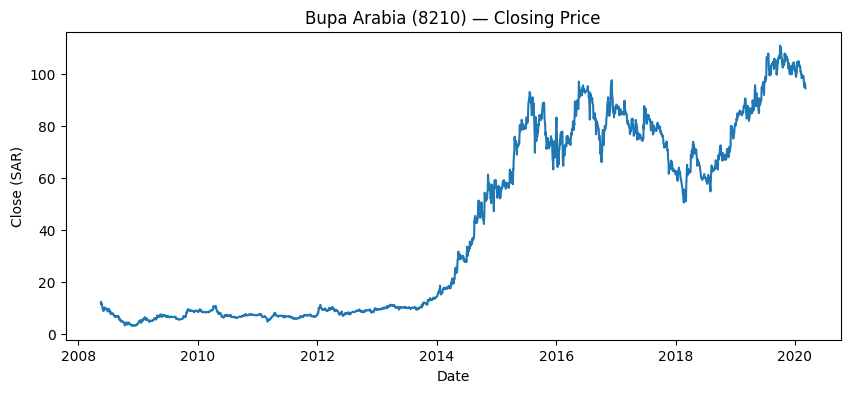

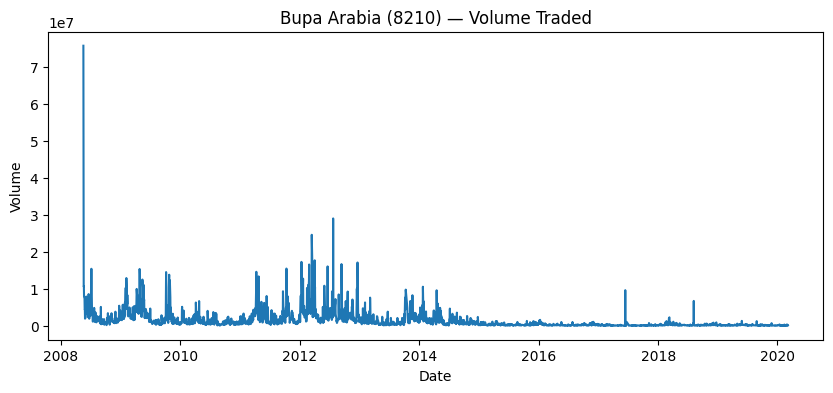

In [7]:
plt.figure(figsize=(10,4))
plt.plot(stock["date"], stock["close"])
plt.title("Bupa Arabia (8210) — Closing Price")
plt.xlabel("Date"); plt.ylabel("Close (SAR)")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(stock["date"], stock["volume_traded"])
plt.title("Bupa Arabia (8210) — Volume Traded")
plt.xlabel("Date"); plt.ylabel("Volume")
plt.show()


In [8]:
data = stock[["date","close","open","high","low","volume_traded"]].copy()

# lagged targets (yesterday, 2 days ago, …)
for lag in [1,2,3,5,10]:
    data[f"close_lag_{lag}"] = data["close"].shift(lag)

# rolling stats
data["ma_5"]  = data["close"].rolling(5).mean()
data["ma_20"] = data["close"].rolling(20).mean()
data["std_20"] = data["close"].rolling(20).std()

# drop first rows with NaNs from shifts/rolls
data = data.dropna().reset_index(drop=True)

# target = next-day close
data["target"] = data["close"].shift(-1)
data = data.dropna().reset_index(drop=True)

feature_cols = [c for c in data.columns if c not in ["date","target"]]
X = data[feature_cols].values
y = data["target"].values
dates = data["date"].values  # keep for plotting later
X.shape, y.shape


((2926, 13), (2926,))

In [9]:
# 80/20 split by time (no shuffling)
split_idx = int(len(data)*0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
dates_train, dates_test = dates[:split_idx], dates[split_idx:]
len(X_train), len(X_test)


(2340, 586)

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

pred = rf.predict(X_test)

rmse = math.sqrt(mean_squared_error(y_test, pred))
mae  = mean_absolute_error(y_test, pred)
r2   = r2_score(y_test, pred)

print(f"RMSE: {rmse:.3f}  |  MAE: {mae:.3f}  |  R²: {r2:.3f}")


RMSE: 5.252  |  MAE: 3.607  |  R²: 0.908


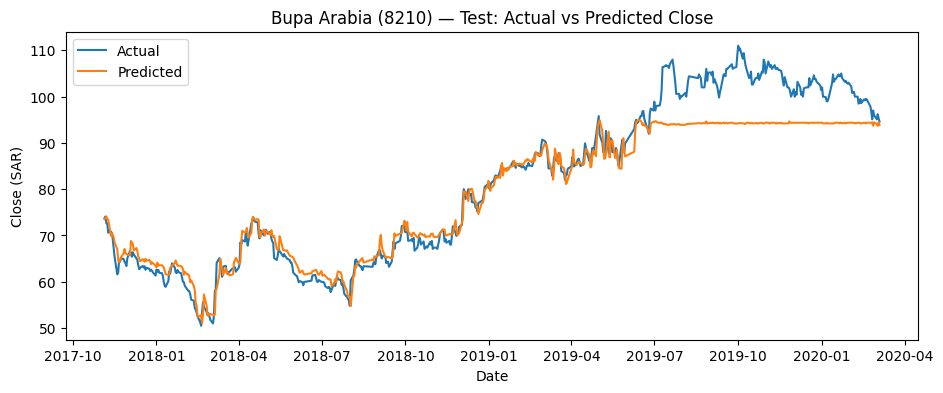

In [11]:
plt.figure(figsize=(11,4))
plt.plot(dates_test, y_test, label="Actual")
plt.plot(dates_test, pred, label="Predicted")
plt.title("Bupa Arabia (8210) — Test: Actual vs Predicted Close")
plt.xlabel("Date"); plt.ylabel("Close (SAR)")
plt.legend()
plt.show()


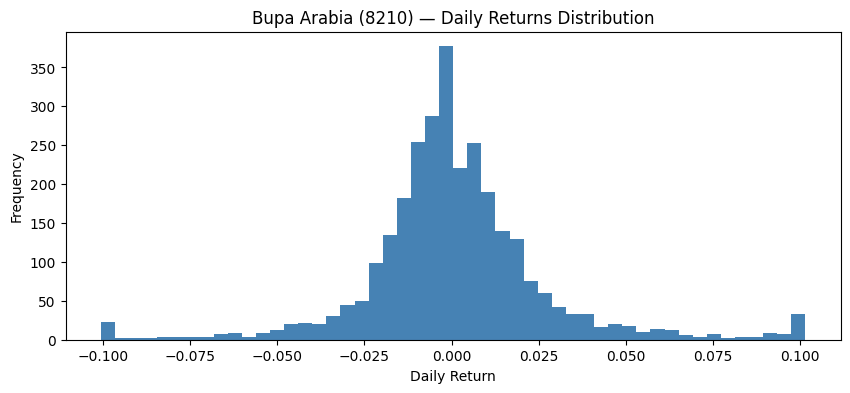

In [12]:
stock['returns'] = stock['close'].pct_change()
plt.figure(figsize=(10,4))
plt.hist(stock['returns'].dropna(), bins=50, color='steelblue')
plt.title("Bupa Arabia (8210) — Daily Returns Distribution")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.show()


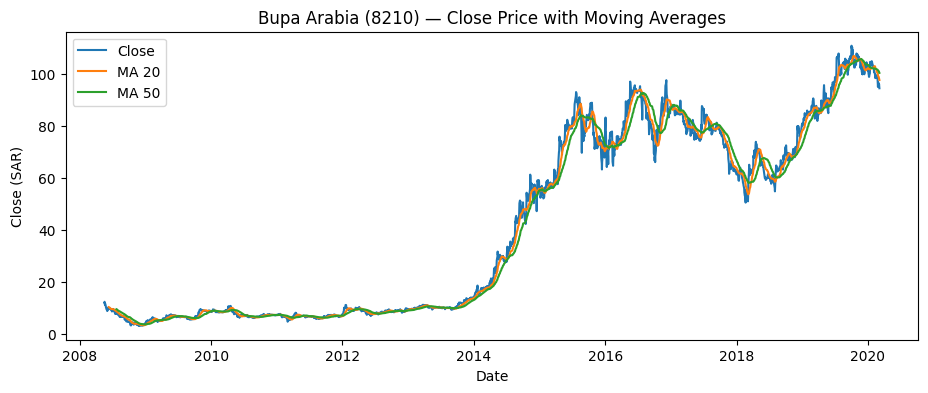

In [13]:
plt.figure(figsize=(11,4))
plt.plot(stock['date'], stock['close'], label='Close')
plt.plot(stock['date'], stock['close'].rolling(20).mean(), label='MA 20')
plt.plot(stock['date'], stock['close'].rolling(50).mean(), label='MA 50')
plt.title("Bupa Arabia (8210) — Close Price with Moving Averages")
plt.xlabel("Date"); plt.ylabel("Close (SAR)")
plt.legend()
plt.show()


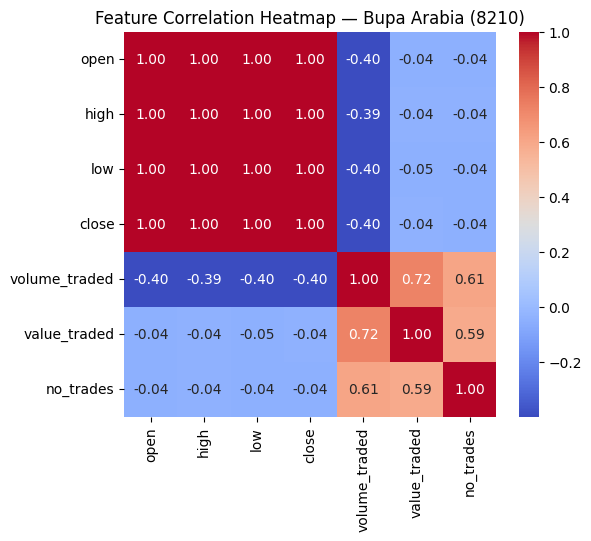

In [15]:
import seaborn as sns

eda_cols = ["open","high","low","close","volume_traded","value_traded","no_trades"]
corr = stock[eda_cols].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap — Bupa Arabia (8210)")
plt.show()


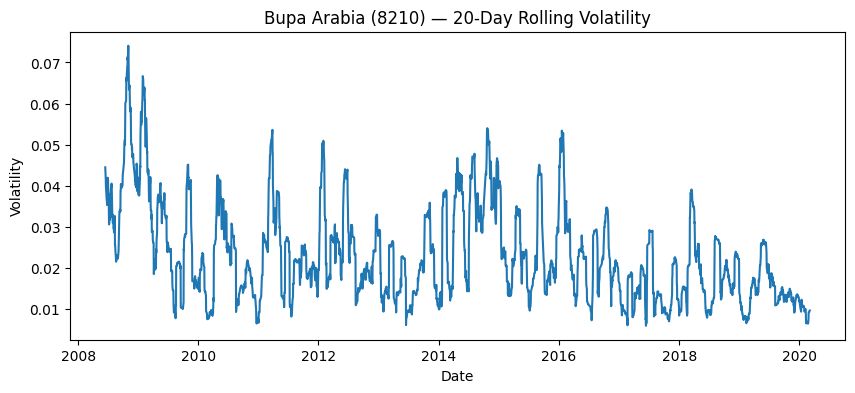

In [16]:
stock['volatility_20'] = stock['returns'].rolling(20).std()

plt.figure(figsize=(10,4))
plt.plot(stock['date'], stock['volatility_20'])
plt.title("Bupa Arabia (8210) — 20-Day Rolling Volatility")
plt.xlabel("Date"); plt.ylabel("Volatility")
plt.show()


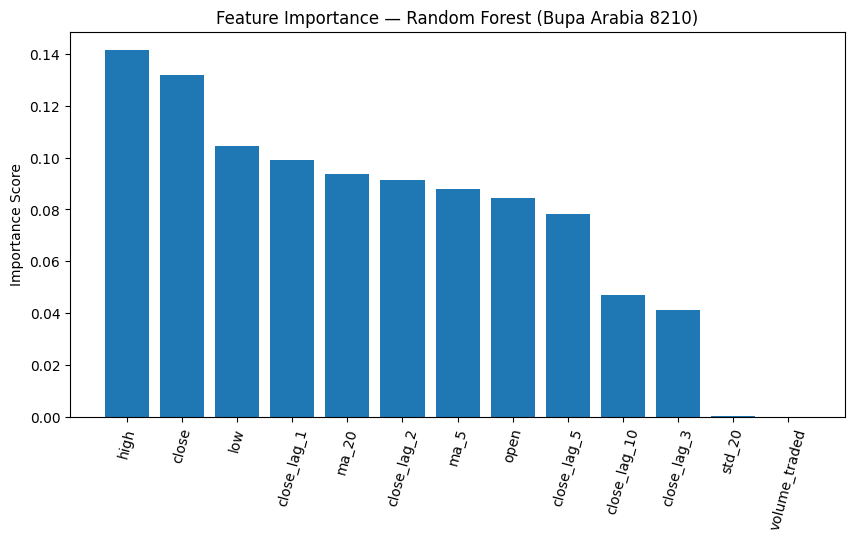

In [17]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,5))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), np.array(feature_cols)[indices], rotation=75)
plt.title("Feature Importance — Random Forest (Bupa Arabia 8210)")
plt.ylabel("Importance Score")
plt.show()


In [18]:
def walk_forward_backtest(df, model, feature_cols, target_col="target", train_size=0.7):
    preds = []
    actual = []
    dates = []

    split_idx = int(len(df) * train_size)

    for i in range(split_idx, len(df)):
        train = df.iloc[:i]
        test = df.iloc[i:i+1]

        X_train = train[feature_cols].values
        y_train = train[target_col].values

        X_test = test[feature_cols].values
        y_test = test[target_col].values

        model.fit(X_train, y_train)
        pred = model.predict(X_test)

        preds.append(pred[0])
        actual.append(y_test[0])
        dates.append(test["date"].values[0])

    return np.array(preds), np.array(actual), np.array(dates)


[WALK FORWARD] RMSE: 1.533 | MAE: 1.122 | R²: 0.989


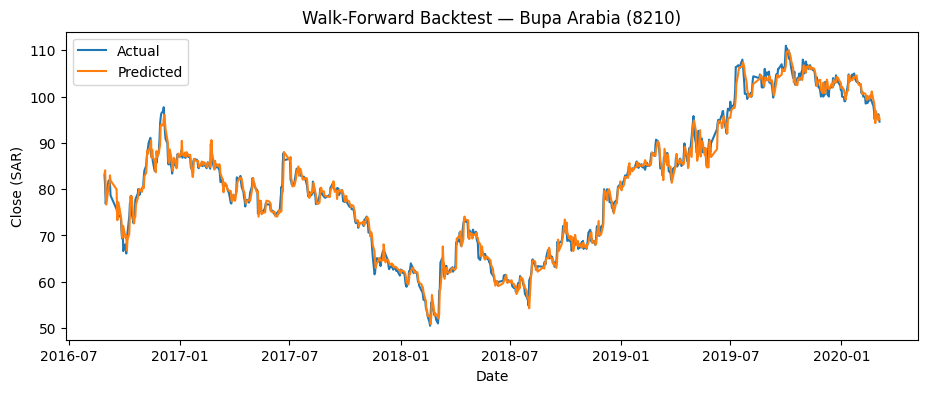

In [19]:
pred_wf, actual_wf, dates_wf = walk_forward_backtest(data, rf, feature_cols)

rmse_wf = math.sqrt(mean_squared_error(actual_wf, pred_wf))
mae_wf  = mean_absolute_error(actual_wf, pred_wf)
r2_wf   = r2_score(actual_wf, pred_wf)

print(f"[WALK FORWARD] RMSE: {rmse_wf:.3f} | MAE: {mae_wf:.3f} | R²: {r2_wf:.3f}")

plt.figure(figsize=(11,4))
plt.plot(dates_wf, actual_wf, label="Actual")
plt.plot(dates_wf, pred_wf, label="Predicted")
plt.title("Walk-Forward Backtest — Bupa Arabia (8210)")
plt.xlabel("Date"); plt.ylabel("Close (SAR)")
plt.legend()
plt.show()


The goal of this project is to build a machine learning model that can predict the next-day closing price of Bupa Arabia (Tadawul symbol: 8210) using historical stock market data from the Saudi Stock Exchange (Tadawul). The model is trained on features engineered from past prices, moving averages, lagged values, and trading activity such as volume. This problem is a supervised regression task where the target variable is the closing price of the following trading day. The main objective is to evaluate whether traditional ML models, such as Random Forest, can capture meaningful pricing patterns and provide reliable forecasts suitable for financial decision support.


The Random Forest model achieved an R² score of 0.908 and a test RMSE of 5.25 SAR, indicating strong predictive performance. The predicted prices followed the real trend closely during most of the test period, although the model struggled when the market experienced sudden changes in direction. This behavior is expected, as tree-based models rely on historical patterns and do not inherently account for market regime shifts. The feature importance results show that the most influential predictors were recent lagged prices and short-term moving averages, confirming that price momentum is an important factor in this stock.


The results demonstrate that machine learning can predict short-term price movements for Bupa Arabia with high accuracy under normal market conditions. However, the model still reacts slowly to rapid price reversals, and performance could be improved by integrating more advanced time-series methods. Future work may include experimenting with deep learning architectures such as LSTM networks, adding macro-economic or sentiment features, and applying hyperparameter optimization. A full walk-forward validation confirms that the model generalizes reasonably well over time, although performance degrades slightly further away from the training window.


A walk-forward validation was implemented to assess model stability over time.
The model was retrained sequentially and evaluated day by day, simulating a realistic
forecasting scenario. The Random Forest achieved an R² of 0.989 and an RMSE of 1.53 SAR,
indicating exceptional predictive accuracy. The predicted curve closely tracks
the actual closing prices, confirming the model’s robustness across changing
market conditions.
